In [7]:
import pandas as pd
import numpy as np

In [9]:
# --- PATHS & FLAGS ----------------------------------------------------
from pathlib import Path
import pandas as pd, requests, io

# Base URL of my GitHub repo (raw view)
BASE_URL = ("https://raw.githubusercontent.com/"
            "Eugine-Srb/Sales-Forecasting_2024-Project/main/")


DATA_PROC_URL = BASE_URL + "data/raw/"     # for imports

# Local fallback folders (never pushed)
EXPORT_DIR = Path("../scratch_outputs")
EXPORT_DIR.mkdir(exist_ok=True)

# Master switch — keep False unless *really* want to re-export
SAVE_OUTPUTS = False

In [11]:
def load_processed(name: str) -> pd.DataFrame:
    """Load a frozen CSV straight from GitHub raw URL."""
    url = DATA_PROC_URL + name
    return pd.read_csv(url, low_memory=False)   # pandas handles https URLs

In [ ]:
# Load the Product Sales dataset

df = load_processed("01_company_data_raw.csv")

In [113]:
# Exploring the contents of the dataset
df.head(10)

,Date,Revenue,Expenses,Employees
0,2019-01-01,104967.141530,55687.431859,55
1,2019-02-01,112821.192576,66851.370563,45
2,2019-03-01,130472.042383,64440.079435,59
3,2019-04-01,141293.972020,64872.344457,50
4,2019-05-01,NaN,79367.371894,52
5,2019-06-01,106655.429968,77604.239980,49
6,2019-07-01,113672.885797,58080.363491,48
7,2019-08-01,99716.932103,64257.346968,46
8,2019-09-01,90152.035232,60162.791680,50
9,2019-10-01,NaN,57969.839592,50


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       60 non-null     object 
 1   Revenue    54 non-null     float64
 2   Expenses   54 non-null     float64
 3   Employees  60 non-null     int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 2.0+ KB


In [115]:
df.describe()

,Revenue,Expenses,Employees
count,54.000000,54.000000,60.000000
mean,156951.633731,95152.439198,51.366667
std,39731.043722,26112.236783,4.364598
min,90152.035232,55687.431859,45.000000
25%,121864.424380,74740.088890,47.750000
50%,154173.511716,95047.499938,51.000000
75%,182306.901113,112955.818646,55.000000
max,240438.368622,162762.142453,59.000000


In [116]:
# Inspecting missing values
df.isna().sum()

Date         0
Revenue      6
Expenses     6
Employees    0
dtype: int64

In [117]:
df[df.isna().any(axis=1)]

,Date,Revenue,Expenses,Employees
4,2019-05-01,NaN,79367.371894,52
9,2019-10-01,NaN,57969.839592,50
11,2019-12-01,134316.978593,NaN,59
12,2020-01-01,151276.915850,NaN,45
14,2020-03-01,NaN,60615.679475,56
15,2020-04-01,120733.772439,NaN,55
22,2020-11-01,NaN,117462.621738,48
37,2022-02-01,120718.430447,NaN,45
49,2023-02-01,177786.082308,NaN,56
52,2023-05-01,NaN,147985.784915,48


In [118]:
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], errors = 'coerce')

In [119]:
# Extract month and year for further analysis and visualization
df['Month'] = df['Date'].dt.strftime('%b')
df['Year'] = df['Date'].dt.year

In [120]:
# Preporation to interpolation
df_original = df.copy()
df_interpolated = df.copy()

In [121]:
# Interpolation missing values in the 'Revenue' column
df_interpolated['Revenue'] = df_interpolated['Revenue'].interpolate(method='linear', limit_direction='both')

In [122]:
# Create mask to locate originally missing Revenue values
missing_mask_revenue = df['Revenue'].isna()

In [123]:
import matplotlib.pyplot as plt
import seaborn as sns

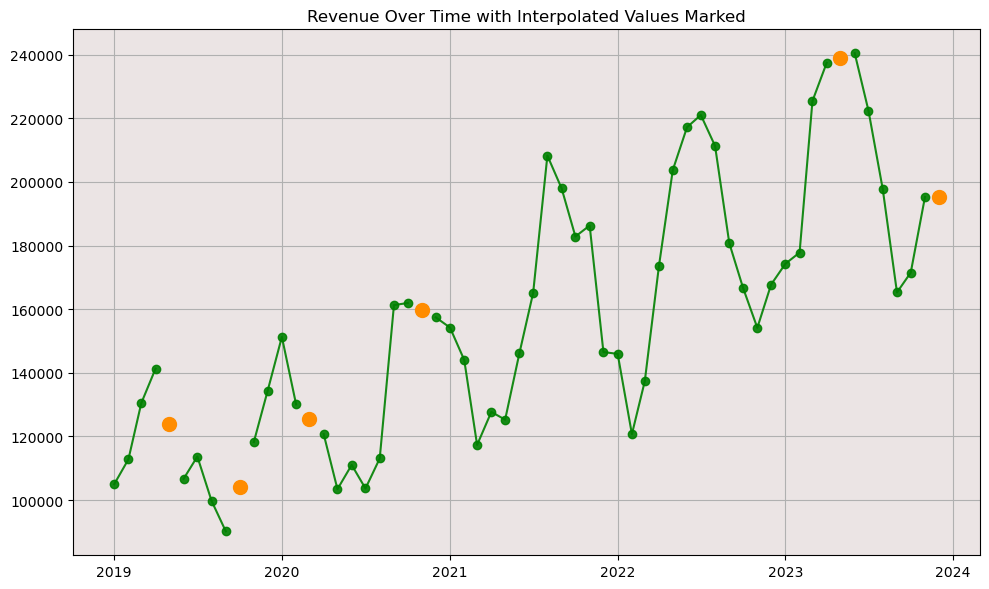

In [124]:
# Revenue Over Time with Interpolated Values Marked
fig, ax = plt.subplots(figsize=(10,6))

# Plot 1: Original data (with NaN) — red dashed line with X markers
ax.plot(df_original['Date'], 
         df_original['Revenue'],
         linestyle='-', 
         marker='o', 
         color='green', 
         label='Original (with NaN)',
         alpha=0.9)

ax.scatter(df_interpolated.loc[missing_mask_revenue, 'Date'],
            df_interpolated.loc[missing_mask_revenue, 'Revenue'],
            color='darkorange',
            label='Interpolated Points',
            s=100,
            zorder=5)
ax.set_facecolor('#ebe4e4')
ax.grid(True)
plt.xlabel('')
plt.title('Revenue Over Time with Interpolated Values Marked')
plt.tight_layout()
plt.show();

In [125]:
# Interpolation missing values in the 'Expenses' column
df_interpolated['Expenses'] = df_interpolated['Expenses'].interpolate(method='linear', limit_direction='both')

In [126]:
# Create mask to locate originally missing Expenses values
missing_mask_expenses = df['Expenses'].isna()

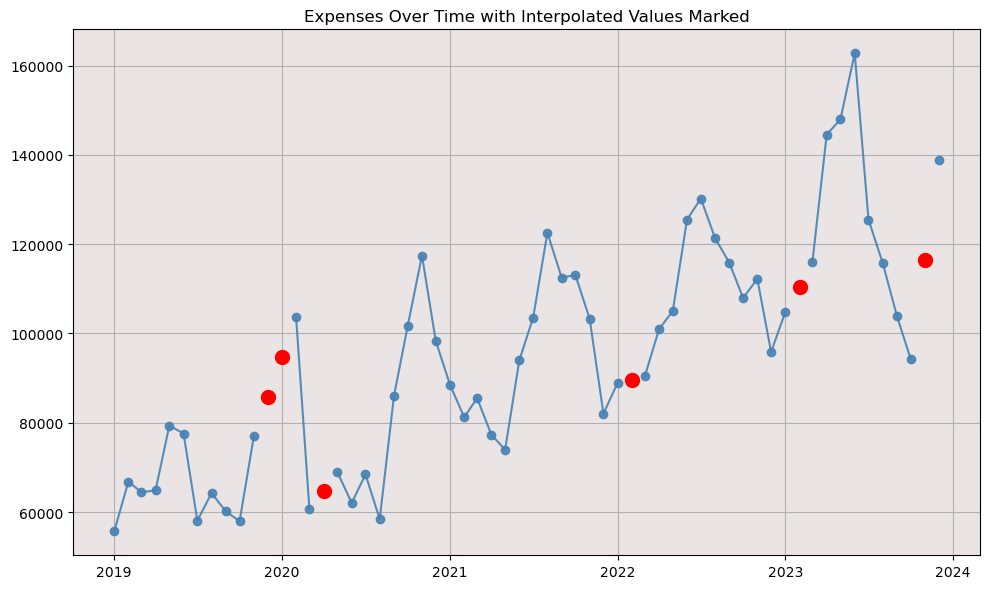

In [127]:
# Revenue Over Time with Interpolated Values Marked
fig, ax = plt.subplots(figsize=(10,6))

# Plot 1: Original data (with NaN) — red dashed line with X markers
ax.plot(df_original['Date'], 
         df_original['Expenses'],
         linestyle='-', 
         marker='o', 
         color='steelblue', 
         label='Original (with NaN)',
         alpha=0.9)

ax.scatter(df_interpolated.loc[missing_mask_expenses, 'Date'],
            df_interpolated.loc[missing_mask_expenses, 'Expenses'],
            color='red',
            label='Interpolated Points',
            s=100,
            zorder=5)
ax.set_facecolor('#ebe4e4')
ax.grid(True)
plt.xlabel('')
plt.title('Expenses Over Time with Interpolated Values Marked')
plt.tight_layout()
plt.show();

In [128]:
# Verify that all NaN values have been handled
df_interpolated.isna().sum()

Date         0
Revenue      0
Expenses     0
Employees    0
Month        0
Year         0
dtype: int64

In [129]:
# Create DataFrame with imputed Revenue points
highlight_points_revenue = df_interpolated.loc[missing_mask_revenue, ['Date', 'Revenue']].copy()
highlight_points_revenue['Imputed_Revenue'] = True

In [130]:
# Create DataFrame with imputed Expenses points
highlight_points_expenses = df_interpolated.loc[missing_mask_expenses,['Date','Expenses']].copy()
highlight_points_expenses['Imputed_Expenses'] = True

In [131]:
# Create a copy of the interpolated dataset for annotation
highlight_points = df_interpolated.copy()

In [132]:
# Mark which rows had 'Revenue' or 'Expenses' values imputed
highlight_points['Revenue_Imputed'] = missing_mask_revenue
highlight_points['Expenses_Imputed'] = missing_mask_expenses

In [133]:
# Keep only rows where at least one column was imputed
highlight_points = highlight_points[highlight_points[['Revenue_Imputed', 'Expenses_Imputed']].any(axis=1)]

In [ ]:
def maybe_save(df: pd.DataFrame, filename: str):
    """
    Save to scratch_outputs/ only if SAVE_OUTPUTS is True.
    Prevents overwriting the canonical CSVs in data/processed/.
    """
    if SAVE_OUTPUTS:
        df.to_csv(EXPORT_DIR / filename, index=False)
        print(f"🔸 Saved {filename} to {EXPORT_DIR}")
    else:
        print(f"⏩ Skipped saving {filename} (SAVE_OUTPUTS = False)")

In [ ]:
maybe_save(highlight_points_expenses, "05-company_data_expenses_interpolated.csv")

In [ ]:
maybe_save(df_interpolated, "06-company_data_interpolated.csv")

In [ ]:
maybe_save(highlight_points_revenue, "07-company_data_revenue_interpolated.csv")